In [1]:
import ugradio
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import dish
import cartopy.crs as ccrs
from scipy.interpolate import interp2d
from tqdm import tqdm, trange
%matplotlib inline

No module named 'rtlsdr'


In [2]:
def calibrate(data_nd0, data_nd1, pol):
    diff = np.array(data_nd1) - np.array(data_nd0)
    if pol == 0:
        T = 90
    elif pol == 1:
        T = 65
    else: print('Bruh its literally either a 0 or 1 you cant fuck it up')
    G = T/diff
    t_line = G * data_nd0
    return t_line

def calibrate1(data_nd0, data_nd1, pol):
    diff = np.median(np.array(data_nd1) - np.array(data_nd0))
    if pol == 0:
        T = 90
    elif pol == 1:
        T = 65
    else: print('Bruh its literally either a 0 or 1 you cant fuck it up')
    G = T/diff
    t_line = G * data_nd0
    return t_line

def calibrate2(data_nd0, data_nd1, pol):
    
    F_low = 146.5
    F_high = 148.5
    freq = np.linspace(144,156,8192)
    condition = (freq >= F_low) * (freq <= F_high)
    trunc_freq = freq[condition]
    
    diff = np.median(np.array(data_nd1[:,condition]) - np.array(data_nd0[:,condition]))
    
    if pol == 0:
        T = 90
    elif pol == 1:
        T = 65
    else: print('Bruh its literally either a 0 or 1 you cant fuck it up')
        
    G = T/diff
    t_line = G * data_nd0
    return t_line

In [3]:
nfiles = 697
nfreq = 8192

In [4]:
nspec = 50

list_0 = np.empty((nfiles, nspec, nfreq))
list_1 = np.empty((nfiles, nspec, nfreq))

for i in trange(nfiles):
    
    f = fits.open(f'lab4_data/{i}_nd0.fits')
    
    for j in range(nspec):
        
        list_0[i,j] = f[j+1].data['auto0_real']
        
        list_1[i,j] = f[j+1].data['auto1_real']

100%|██████████| 697/697 [02:30<00:00,  4.63it/s]


In [5]:
noise_spec = 5

noise_0 = np.empty((nfiles, noise_spec, nfreq))
noise_1 = np.empty((nfiles, noise_spec, nfreq))

for i in trange(nfiles):
    
    f = fits.open(f'lab4_data/{i}_nd1.fits')
    
    for j in range(noise_spec):
        
        noise_0[i,j] = f[j+1].data['auto0_real']
        
        noise_1[i,j] = f[j+1].data['auto1_real']

100%|██████████| 697/697 [00:16<00:00, 42.23it/s]


In [6]:
median_specs_0 = np.median(list_0, axis=1)
median_specs_1 = np.median(list_1, axis=1)

In [7]:
median_noise_0 = np.median(noise_0, axis=1)
median_noise_1 = np.median(noise_1, axis=1)

In [8]:
Tline_0 = calibrate2(median_specs_0, median_noise_0, 0)
Tline_1 = calibrate2(median_specs_1, median_noise_1, 1)

In [19]:
F_low = 149.5
F_high = 150.5
freq = np.linspace(144,156,8192)
condition = (freq >= F_low) * (freq <= F_high)

ctline_0 = np.empty((nfiles, nfreq))
ctline_1 = np.empty((nfiles, nfreq))

for i in trange(nfiles):
    sub_0 = Tline_0[i] - np.median(Tline_0[i,condition])
    ctline_0[i] = sub_0
    sub_1 = Tline_1[i] - np.median(Tline_1[i,condition])
    ctline_1[i] = sub_1

100%|██████████| 697/697 [00:00<00:00, 3286.77it/s]


In [20]:
T_0 = np.max(ctline_0, axis=1)
T_1 = np.max(ctline_1, axis=1)

In [22]:
coords = np.array(dish.bubble_coords())
df_0 = pd.DataFrame({'l':coords[:,0], 'b':coords[:,1], 'T_0':T_0})
df_0.drop(df_0.index[df_0['T_0'] == T_0.max()], inplace=True)

l_0 = df_0['l']
b_0 = df_0['b']
T_0 = df_0['T_0']
T_0.max()

196.70955855169916

In [23]:
df_1 = pd.DataFrame({'l':coords[:,0], 'b':coords[:,1], 'T_1':T_1})
df_1.drop(df_1.index[df_1['T_1'] > 300], inplace=True)

l_1 = df_1['l']
b_1 = df_1['b']
T_1 = df_1['T_1']
T_1.max()

297.9228804328073

In [24]:
df_0.to_csv('T_0_temps')
df_1.to_csv('T_1_temps')

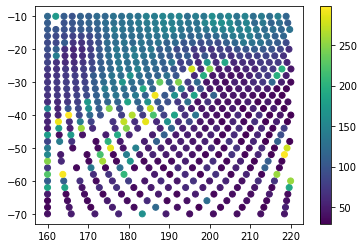

In [32]:
plt.scatter(l_1, b_1, c=T_1)
#plt.scatter(x,y,alpha=0.5)
plt.colorbar()

Text(0.5, 0, '$\\ell$ [Deg]')

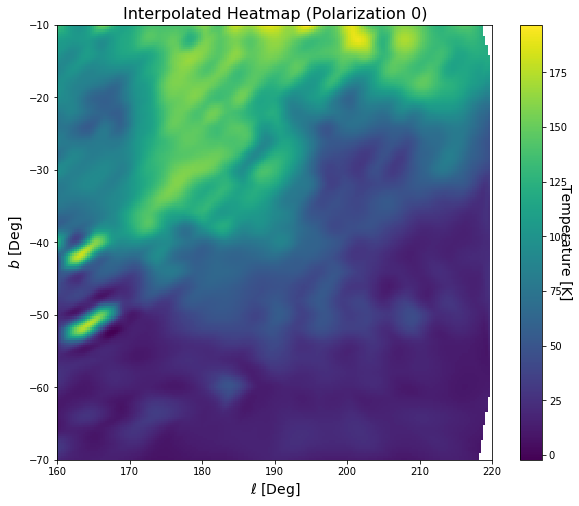

In [34]:
from scipy import interpolate

fig, axs = plt.subplots(1, 1, figsize=[10,8], sharex=True, sharey=True)

points_0 = (l_0, b_0)
points_1 = (l_1, b_1)

grid_x_0, grid_y_0 = np.mgrid[l_0.min():l_0.max():200j, b_0.min():b_0.max():200j]
grid_x_1, grid_y_1 = np.mgrid[l_1.min():l_1.max():200j, b_1.min():b_1.max():200j]

cubic_grid_0 = interpolate.griddata(points_0, T_0, (grid_x_0, grid_y_0), method='cubic')
cubic_grid_1 = interpolate.griddata(points_1, T_1, (grid_x_1, grid_y_1), method='cubic')

im1 = axs.imshow(cubic_grid_0.T, extent=[160, 220, -70, -10], origin='lower', cmap='viridis')
fig.colorbar(im1, ax=axs).set_label('Temperature [K]', rotation=270, fontsize=14)
axs.set_title('Interpolated Heatmap (Polarization 0)', fontsize=16)
axs.set_ylabel(r'$b$ [Deg]', fontsize=14)
axs.set_xlabel(r'$\ell$ [Deg]', fontsize=14)

# im2 = axs[1].imshow(cubic_grid_1.T, extent=[160, 220, -70, -10], origin='lower', cmap='viridis')
# fig.colorbar(im2, ax=axs[1])#.set_label('Temperature [K]', rotation=270, fontsize=12)
# axs[1].set_title('Interpolated T_1')

In [27]:
# cgs = pd.DataFrame({'cubic_grid_0':cubic_grid_0.T, 'cubic_grid_1':cubic_grid_1.T})
# cgs.to_csv('cubic_grid_data')

In [28]:
import cartopy.crs as ccrs
from cartopy.mpl import gridliner

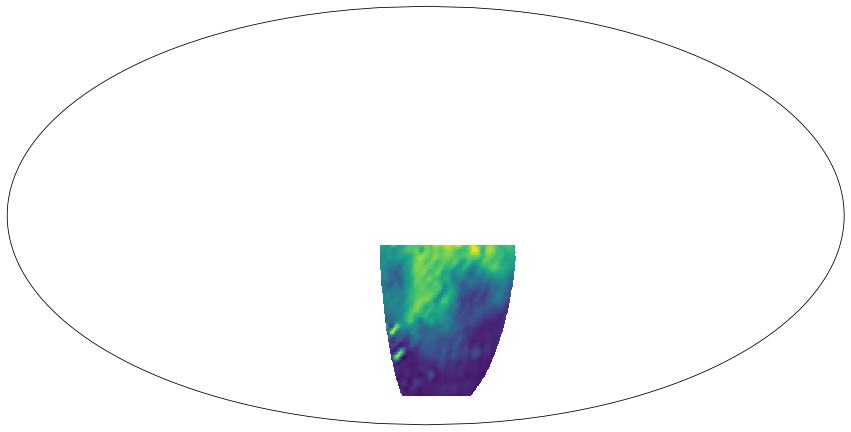

In [29]:
import matplotlib.ticker as mticker

fig, ax = plt.subplots(subplot_kw={'projection':ccrs.Mollweide()}, figsize=(15,15))

ax.imshow(cubic_grid_0.T, extent=[160-180,220-180,-10,-70], transform=ccrs.PlateCarree())
ax.grid()
#gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
# gl.xlocator = mticker.FixedLocator([160-180, 180-180, 200-180, 220-180])
# gl.xformatter = gridliner.LONGITUDE_FORMATTER
# gl.yformatter = gridliner.LATITUDE_FORMATTER